# Using QPU selectors directly

##### First, let's take a glance at all of the backends available to us via Qiskit Runtime. We will ignore all simulators.

In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

for backend in service.backends(simulator=False):
    print(
        f"Backend name: {backend.name}    ",
        f"Status: {backend.status().status_msg}    ",
        f"Operational: {backend.status().operational}    ",
        f"Queue size: {backend.status().pending_jobs}    ",
        f"# qubits: {backend.num_qubits}",
    )

Backend name: ibm_nazca     Status: active     Operational: True     Queue size: 9     # qubits: 127
Backend name: ibmq_mumbai     Status: active     Operational: True     Queue size: 20     # qubits: 27
Backend name: ibm_cairo     Status: active     Operational: True     Queue size: 8     # qubits: 27
Backend name: ibm_perth     Status: active     Operational: True     Queue size: 847     # qubits: 7
Backend name: ibm_brisbane     Status: active     Operational: True     Queue size: 62     # qubits: 127
Backend name: ibm_algiers     Status: internal     Operational: True     Queue size: 13     # qubits: 27
Backend name: ibm_kyoto     Status: active     Operational: True     Queue size: 0     # qubits: 127
Backend name: ibm_lagos     Status: active     Operational: True     Queue size: 66     # qubits: 7
Backend name: ibm_hanoi     Status: active     Operational: True     Queue size: 177     # qubits: 27
Backend name: ibmq_kolkata     Status: active     Operational: True     Queue size

##### Use `IBMLeastBusyQPUSelector` to select the 127-qubit Eagle backend with the shortest queue.

In [2]:
from quantum_serverless_tools.selectors import IBMLeastBusyQPUSelector

IBMLeastBusyQPUSelector(service).get_backend(min_num_qubits=127)

<IBMBackend('ibm_kyoto')>

##### Create an abstract circuit. We will find the backend on which this circuit maps to the least-noisy subset of qubits.

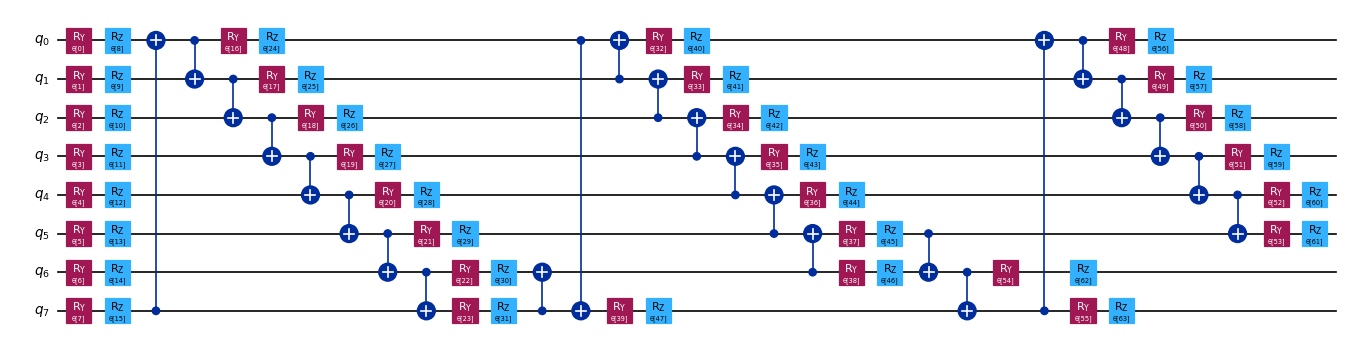

In [3]:
from qiskit.circuit.library import EfficientSU2
from quantum_serverless_tools.selectors import IBMLeastNoisyQPUSelector

qc = EfficientSU2(8, entanglement="sca").decompose()
qc.draw("mpl", scale=0.6, style="iqp", fold=-1)

##### Use `IBMLeastNoisyQPUSelector` to select the 127-qubit Eagle backend which yields the least-noisy qubit subgraph for the given circuit.

In [ ]:
selector = IBMLeastNoisyQPUSelector(service=service, transpile_options={"circuits": qc, "optimization_level": 3})
backend = selector.get_backend(min_num_qubits=127)
optimized_circuit = selector.optimized_circuit
print(f"Selected backend: {backend.name}")
optimized_circuit.draw("mpl", scale=0.6, style="iqp", idle_wires=False, fold=-1)